# How to debug a model

There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC3` uses `Theano` expressions to build the model, and not functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the `Theano` `Print` operatator. For more information, see:  theano Print operator for this before: http://deeplearning.net/software/theano/tutorial/debug_faq.html#how-do-i-print-an-intermediate-value-in-a-function.

Let's build a simple model with just two parameters:

In [14]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import theano.tensor as tt

x = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)

    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5000, step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:02<00:00, 4276.20draws/s]
/Users/twiecki/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [17]:
trace['mu']

array([0., 0., 0., ..., 0., 0., 0.])

Hm, looks like something has gone wrong, but what? Let's look at the values getting proposed using the `Print` operator:

In [11]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)
    
    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)
    
    obs = pm.Normal('obs', mu=mu_print, sigma=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(3, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

mu __str__ = 0.0
sd __str__ = 0.0


Only 3 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


sd __str__ = -1.0187422257064631
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = -0.4591277292273646
mu __str__ = 0.0
sd __str__ = 0.5731278873643482
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 1.9855846003705118
mu __str__ = 0.0
sd __str__ = 0.05734873683282058
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 1.0169032920056222
mu __str__ = 0.0


/Users/twiecki/working/projects/pymc/pymc3/sampling.py:467: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In the code above, we set the `tune=0, chains=1, progressbar=False` in the `pm.sample`, this is done so that the output is cleaner.

Looks like `sd` is always `0` which will cause the logp to go to `-inf`. Of course, we should not have used a prior that has negative mass for `sd` but instead something like a `HalfNormal`.

We can also redirect the output to a string buffer and access the proposed values later on (thanks to [Lindley Lentati](https://github.com/LindleyLentati) for providing this example):

INFO (theano.gof.compilelock): Waiting for existing lock by process '70988' (I am process '70801')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/twiecki/.theano/compiledir_Darwin-18.5.0-x86_64-i386-64bit-i386-3.6.7-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '70988' (I am process '70801')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/twiecki/.theano/compiledir_Darwin-18.5.0-x86_64-i386-64bit-i386-3.6.7-64/lock_dir
Only 5 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
/Users/twiecki/working/projects/pymc/pymc3/sampling.py:467: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


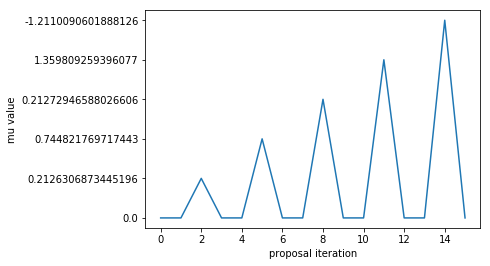

In [12]:
from io import StringIO
import sys

x = np.random.randn(100)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)

    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)

    obs = pm.Normal('obs', mu=mu_print, sigma=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

sys.stdout = old_stdout

output = mystdout.getvalue().split('\n')
mulines = [s for s in output if 'mu' in s]

muvals = [line.split()[-1] for line in mulines]
plt.plot(np.arange(0, len(muvals)), muvals)
plt.xlabel('proposal iteration')
plt.ylabel('mu value');

In [13]:
trace['mu']

array([0., 0., 0., 0., 0.])

Notice that for each iteration, 3 values were printed and recorded. The printed values are the original value (last sample), the proposed value and the accepted value. Plus the starting value in the very beginning, we recorded in total `1+3*5=16` value above.